In [2]:
import sqlite3

curser = sqlite3.connect('divar.db').cursor()

#### Number of posts in database

In [2]:
curser.execute("select count(*) from posts").fetchall()

[(10000,)]

#### Number of posts that have 'پراید' in desc

In [3]:
curser.execute('select count(*) from posts where desc like "%پراید%"').fetchall()

[(164,)]

#### sum of price of posts that have 'ps4' in desc and are published

In [3]:
curser.execute('select count(*), sum(v09) from posts where desc like "%ps4%" and v09 > 0 and is_published').fetchall()

[(8, 13157000.0)]

#### count of posts that have null price

In [5]:
curser.execute('select count(*) from posts where v09 is null').fetchall()

[(1393,)]

#### count of posts grouped by cat1 sorted by count

In [6]:
curser.execute('select cat1, count(*) from posts group by cat1 order by count(*)').fetchall()

[(151, 51),
 (191, 143),
 (79, 510),
 (12, 742),
 (38, 761),
 (1, 884),
 (125, 1151),
 (2, 1421),
 (67, 1640),
 (143, 2697)]

#### count of posts grouped by cat2 for groups that have more than 10 posts

In [7]:
curser.execute('select cat2, count(*) from posts group by cat2 having count(*) > 10 order by count(*) desc limit 20').fetchall()

[(209.0, 1293),
 (68.0, 1206),
 (213.0, 1058),
 (4.0, 859),
 (37.0, 470),
 (None, 408),
 (47.0, 396),
 (137.0, 365),
 (136.0, 326),
 (5.0, 315),
 (13.0, 315),
 (124.0, 274),
 (69.0, 269),
 (221.0, 183),
 (3.0, 172),
 (138.0, 152),
 (73.0, 145),
 (131.0, 141),
 (186.0, 131),
 (14.0, 127)]

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline
sea.set_style('white')

#### consumed time for reviewing posts in days (ignore 109 and 105)

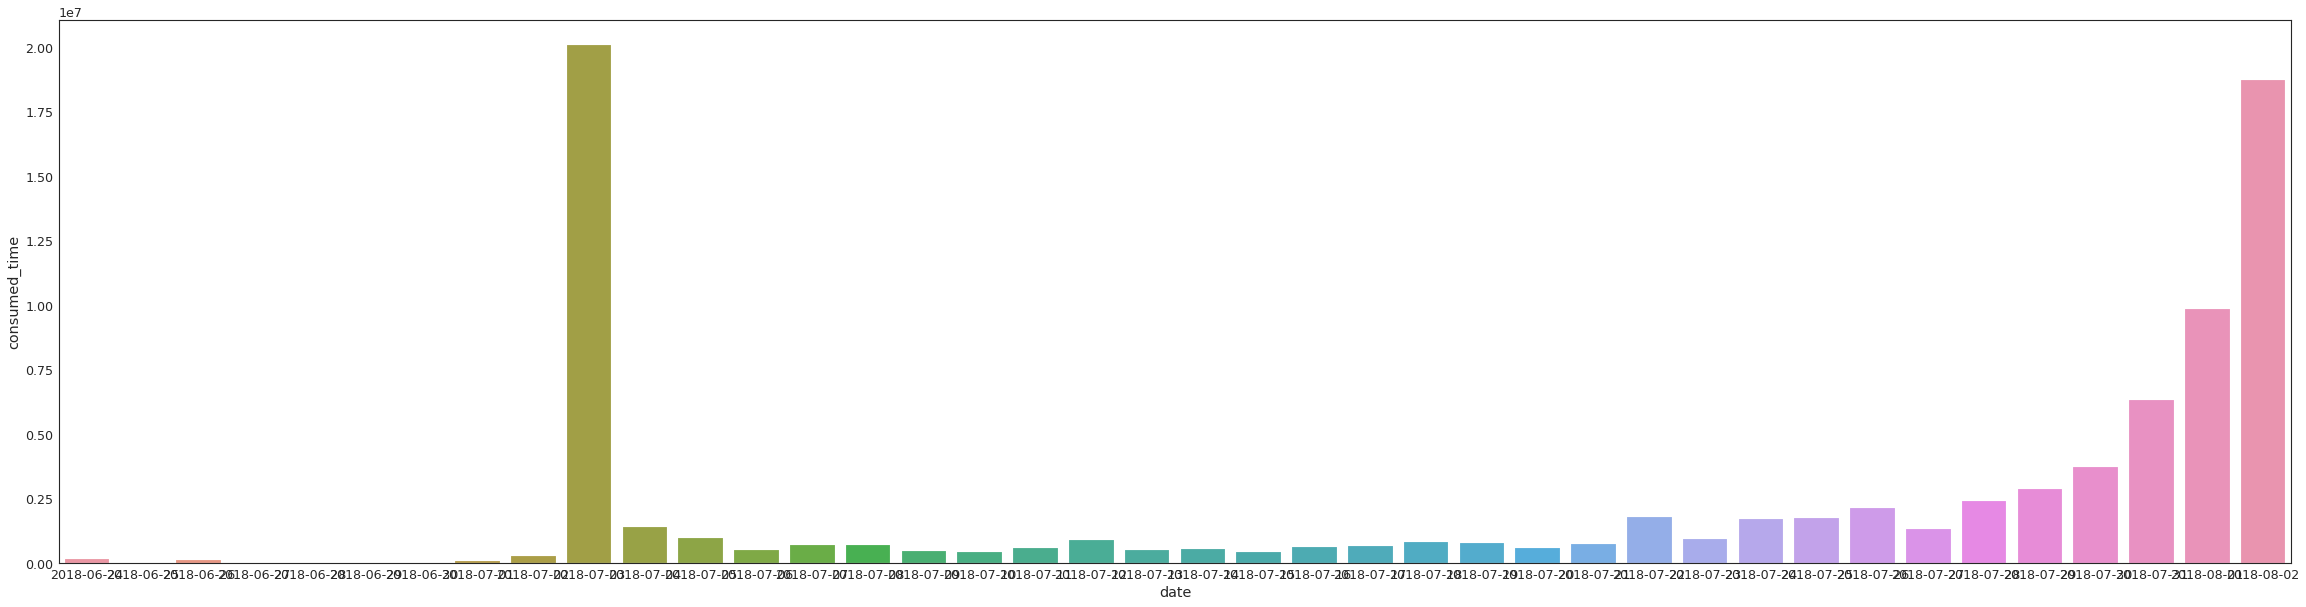

In [6]:
plt.subplots(1, 1, figsize=(40, 10))
consumed_per_date = curser.execute("select strftime('%Y-%m-%d', reviewed_at) as date, sum(consumed_time) from reviews where reviewer != 105 and reviewer != 109 group by date order by date").fetchall()
df = pd.DataFrame(consumed_per_date, columns=['date', 'consumed_time'])
sea.barplot(x='date', y='consumed_time', data=df.loc[20:])

#### review consumed time per main category

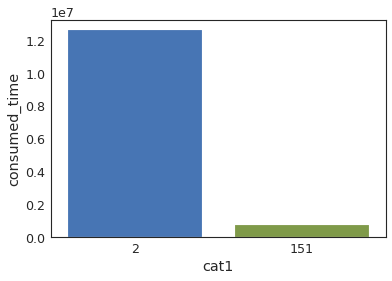

In [30]:
cat_consumed_time = pd.DataFrame(
    curser.execute("select posts.cat1, sum(reviews.consumed_time) from (reviews inner join posts on posts.pk=reviews.pk) group by posts.cat1 having posts.is_published=1").fetchall(),
    columns=['cat1', 'consumed_time'])
sea.barplot(x='cat1', y='consumed_time', data=cat_consumed_time)

#### number of published posts in a week on different cat1s 

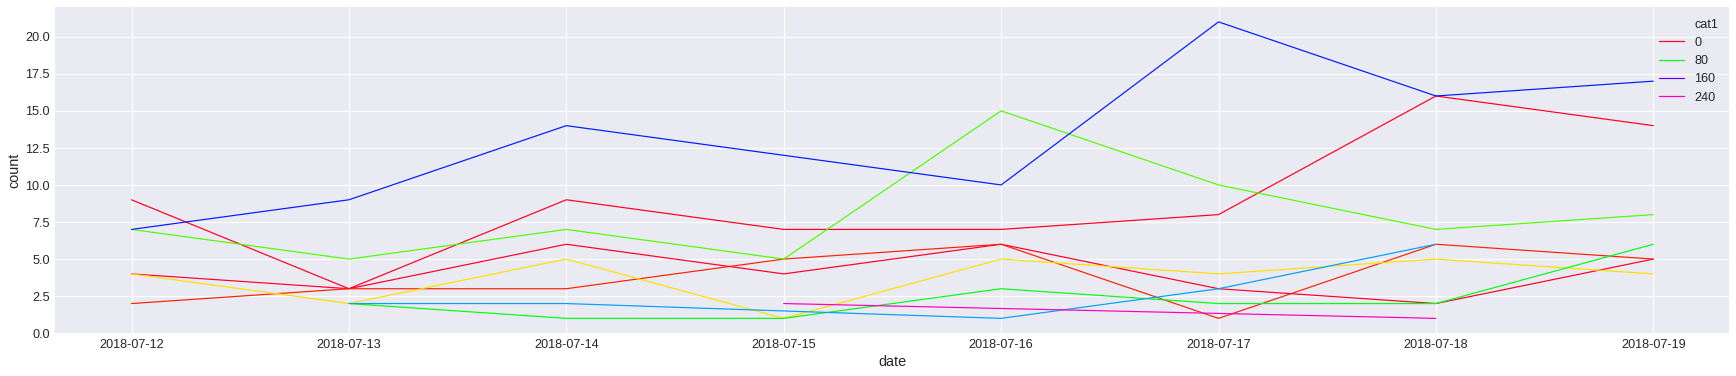

In [76]:
plt.subplots(1, 1, figsize=(30, 6))
df = pd.DataFrame(
    curser.execute(
    "select cat1, strftime('%Y-%m-%d', first_published_at) as publish_day, count(*) from posts where first_published_at >= '2018-07-12' and first_published_at < '2018-07-20' group by cat1, publish_day"
    ).fetchall(),
    columns=['cat1', 'date', 'count'])
sea.lineplot(x='date', y='count', hue='cat1', data=df, palette='gist_rainbow')


#### sum of views of posts that are published by mehrnaz

In [81]:
curser.execute('select stats.view_date, sum(stats.view_count) from posts inner join stats on stats.pk=posts.pk where last_reviewer_id=105 group by stats.view_date').fetchall()

[('2018-07-23', 358),
 ('2018-07-24', 348),
 ('2018-07-25', 304),
 ('2018-07-26', 106),
 ('2018-07-27', 74),
 ('2018-07-28', 58),
 ('2018-07-29', 1592),
 ('2018-07-30', 894),
 ('2018-07-31', 3232),
 ('2018-08-01', 4814),
 ('2018-08-02', 2438)]

#### avg of view/contact for posts

In [9]:
curser.execute(' select cat1, avg(ratio) from (select stats.view_date, posts.cat1, avg(stats.view_count/get_contacts.get_contact_count) as ratio '
               'from (posts inner join stats on stats.pk=posts.pk inner join get_contacts on get_contacts.pk=posts.pk and stats.view_date=get_contacts.get_contact_date) '
               'group by posts.cat1, stats.view_date) group by cat1').fetchall()

[(1, 15.090257642073887),
 (2, 16.88818982788229),
 (12, 17.836852223163863),
 (38, 20.319123417292957),
 (67, 13.651496148336264),
 (79, 10.747947753694735),
 (125, 6.34530992494543),
 (143, 15.29879125426712),
 (151, 22.423241126689398),
 (191, 31.197241458264614)]

#### box plot of view/contact at 2018-12-07 per category

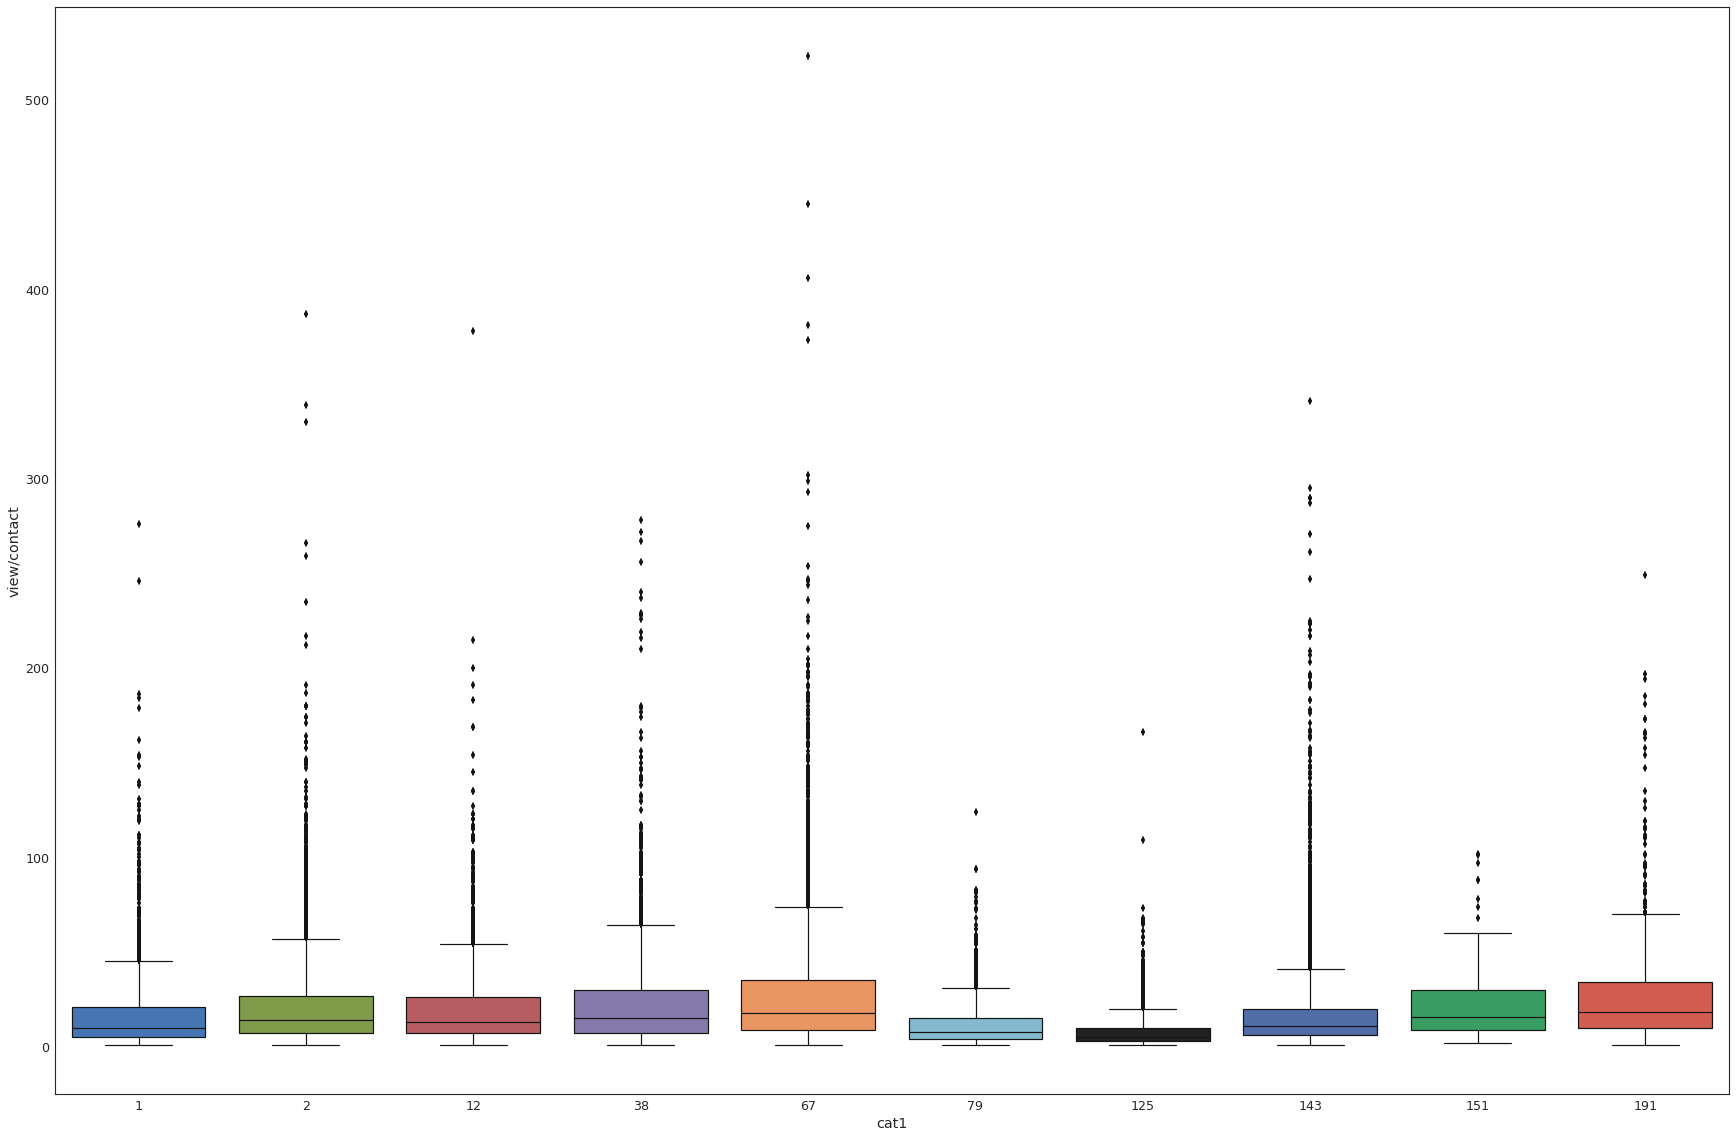

In [11]:
df = pd.DataFrame(
    (
        pair for pair in curser.execute('select posts.cat1, stats.view_count/get_contacts.get_contact_count '
               'from (posts inner join stats on stats.pk=posts.pk inner join get_contacts on get_contacts.pk=posts.pk and stats.view_date=get_contacts.get_contact_date)').fetchall() if pair[1]
    ),
    columns=['cat1', 'view/contact']
)
plt.subplots(1, 1, figsize=(30, 20))
sea.boxplot(x='cat1', y='view/contact', data=df)

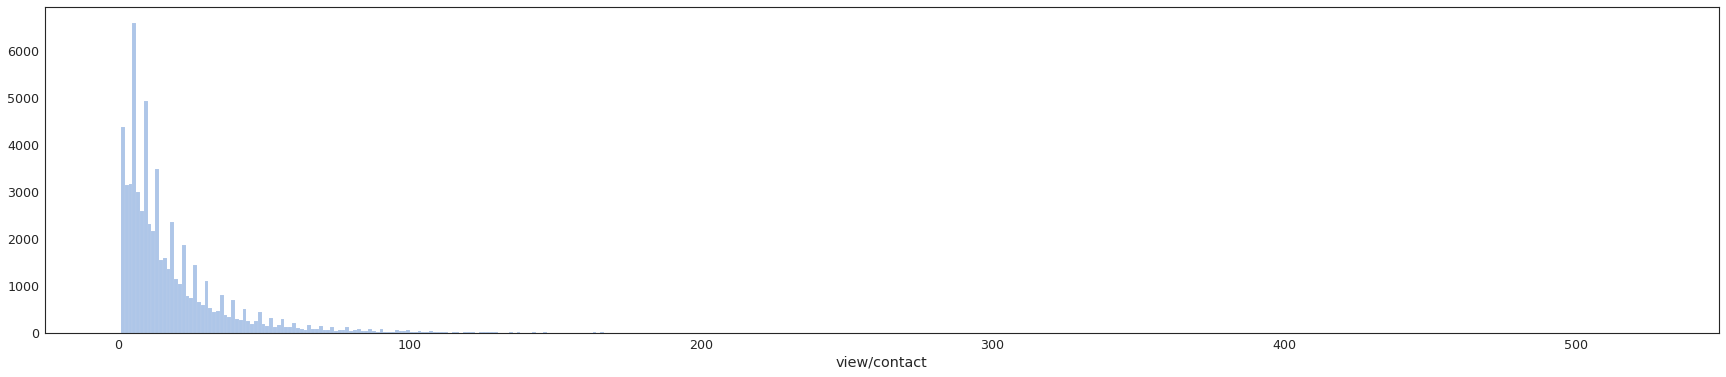

In [12]:
plt.subplots(1, 1, figsize=(30, 6))
sea.distplot(a=df['view/contact'], kde=False, bins=400)

#### scatter plot of created_time vs reviewed_time of last 1000 posts

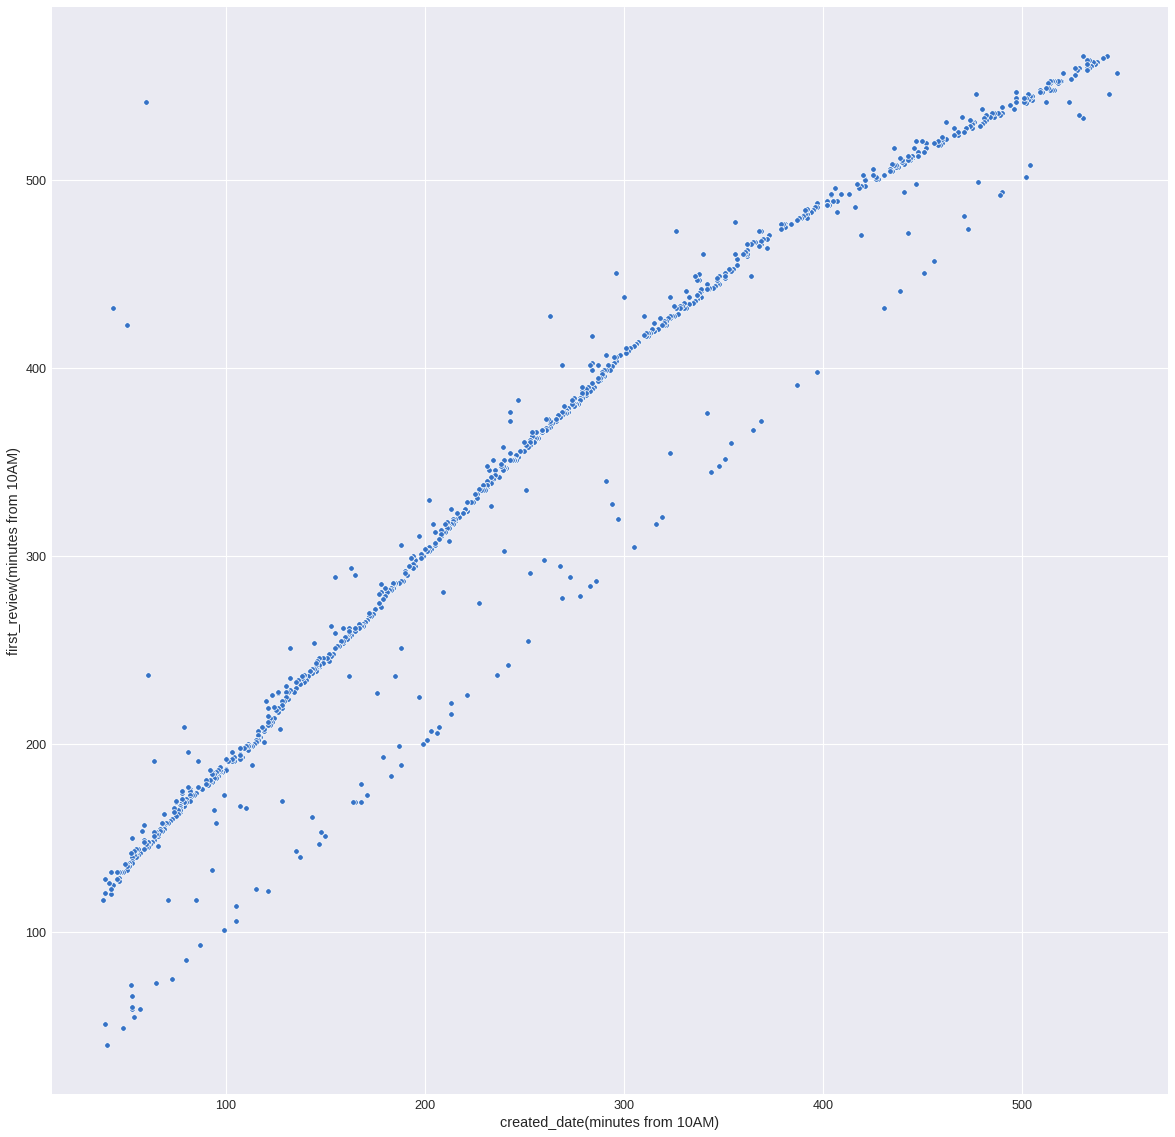

In [132]:
df = pd.DataFrame(
    curser.execute('select created_date, first_reviewed_at from posts order by created_date desc limit 1000').fetchall(),
    columns=['created_date(minutes from 10AM)', 'first_review(minutes from 10AM)']
)
df['created_date(minutes from 10AM)'] = pd.to_datetime(df['created_date(minutes from 10AM)']).apply(lambda x: (x.hour - 10) * 60 + x.minute)
df['first_review(minutes from 10AM)'] = pd.to_datetime(df['first_review(minutes from 10AM)']).apply(lambda x: (x.hour - 10) * 60 + x.minute)
plt.subplots(1, 1, figsize=(20, 20))
sea.scatterplot(x='created_date(minutes from 10AM)', y='first_review(minutes from 10AM)', data=df)

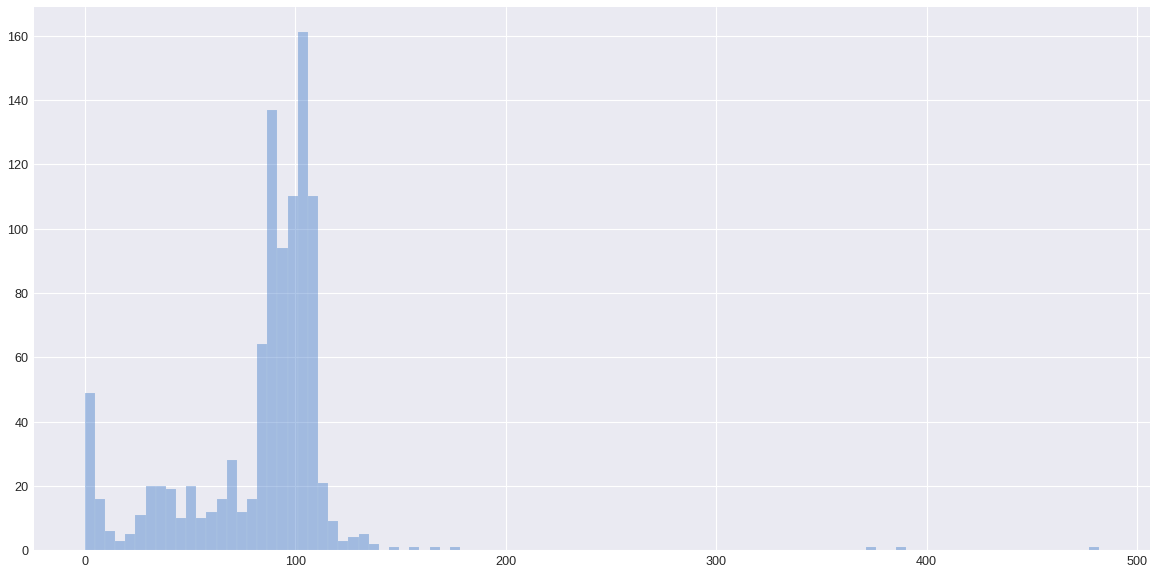

In [143]:
plt.subplots(1, 1, figsize=(20, 10))
sea.distplot(df['first_review(minutes from 10AM)'] - df['created_date(minutes from 10AM)'], bins=100, kde=False)

#### 10 latest posts that have phone number in description

In [162]:
curser.execute('select * from posts where desc like "%09%" order by created_date desc limit 10').fetchall()
# sqlite does not support regular expressions by default, above answer is a workaround and seem to work for now
# another approach could be loading rows one by one and checking if there is a phone number using regexs in python

[(8251,
  202554373,
  '2018-08-02 19:14:48.023150',
  '3',
  'آگهی تکراری است. لطفاً ابتدا آگهی قبلی را از طریق لینک ارائه شده در ایمیل تأییدی حذف کنید.\n به این نکته نیز توجه داشته باشید که طبق قوانین دیوار، تا ۲۴ ساعت پس از حذف آگهی قبلی، قادر به انتشار مجدد آن نخواهید بود.',
  0,
  143,
  209.0,
  210.0,
  None,
  88.0,
  1.0,
  4.0,
  None,
  2.0,
  None,
  None,
  1.0,
  670000000.0,
  None,
  None,
  None,
  '*88متر تک واحدی اردیبهشت جنوبی*',
  '88متر دو خواب طبقه اول\n4واحدی، دوکله\n9ساله، شیک و دیدنی\nاردیبهشت جنوبی\nبا پارکینگ\nفوری فوری\nفروشنده واقعی\nمشاوره تخصصی ملک در منطقه\nمهندس ابیانه/ 09124028805\n*****«««««««املاک اردیبهشت»»»»»»»*****',
  '2018-08-02 18:45:59.830000',
  '2018-08-02 18:45:59.830000',
  '2018-08-02 19:14:47.965000',
  105,
  'XyCUg8MZTS6hJ2JY6g2grA',
  '173.249.38.227',
  '09124028805',
  'beh_ashr@yahoo.com',
  0,
  'A',
  '259',
  229603061,
  None,
  1,
  None,
  108.0,
  35.7541451,
  51.5292134,
  0,
  '0',
  '',
  0,
  0,
  'rIRedwIb4',
  0,
  N